<a href="https://colab.research.google.com/github/aryellewright/Kumar-Lab-Group/blob/main/titration_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports...Imports...Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import glob
import scipy.stats as stats
#from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.optimize
sns.set()

# from google.colab import drive
# drive.mount('/content/drive')

# Locating data and sorting
Upload your csv files to your google drive. Use the '*' symbol to change the directories within your drive to locate your data. Ensure that your files are correct by printing all_files

In [116]:
# locating the data in google drive
# all_files = glob.glob("/*/*/*/*/DMAEMA80-PEG20/*.csv")

# locating the data on your computerf
path = '/Users/aryellewright/Documents/GitHub/Kumar-Biomaterials-Lab/titrations/*.csv'
files = glob.glob(path)

dataframes = [pd.read_csv(file) for file in files]
# sorting and displaying our files
all_files.sort()
all_files

['/content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata1.csv',
 '/content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata2.csv',
 '/content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata3.csv']

When you have trouble uploading data, the following code is used to see your current working directory, since thats usually the problem. 

In [3]:
# determining our current working directory whenever 
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/Users/aryellewright/Documents/GitHub/Kumar-Biomaterials-Lab/titrations': ['titration_code.ipynb']


# Adding a cycle number to keep organize our different csv files
We want to enumerate (combine) all of our csv files. Once we add them together, we want to distinguish from one another via a cycle number. 

In [118]:
# creating an empty list to add our enumerated data to
list_df = []  

# creating an empty list that outputs the max volume of each csv files
# the max volume should be 20mL, but sometimes it's short of that
vols = []

# looping through all of our enumerated csv files 
for i, f in enumerate(all_files):
  print(i, f)
  
  # reading our csv files and adding cycle numbers to our dataframe
  df = pd.read_csv(f)
  df["Cycle Number"] = i
  list_df.append(df)

  # finding the max volume of each csv file and adding to our volumes list
  volume_max = df["Volume (mL)"].max()
  vols.append(volume_max)

#list_df
vols

0 /content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata1.csv
1 /content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata2.csv
2 /content/drive/MyDrive/Titration_data/DMAEMA80-PEG20/T10472_20221206_1641_050_Tdata3.csv


[20.0, 20.0, 20.0]

# Even when we add the files together, sometimes the volumes are incorrect
We have separate csv files because our autotitrator dispenses 20mL in one cycle. This is why there's usually multiple cycles. For exmaple, after two cycles, our final volume should be 40mL, not 20mL. 

Sometimes, the final volume of a cycle isn't 20mL (because the autotitrator hates us?). As a result, the following code adds the volume of the end of one cycle, to the beginning of the next cycle to ensure that the final volumes are compounded.

In [119]:
# creating a list to add the final volume of each csv file to
adjs = [0]

# initiating a counter 
vol_tally = 0

# looping through the vols list from earlier, except for the last volume of our csv file
for volume in vols[:-1]:

  # compounding the volumes and adding them to our adjs list
  vol_tally += volume
  adjs.append(vol_tally)

vol_tally
adjs

[0, 20.0, 40.0]

In [120]:
# looping through our enumerated dataframe
for i, df in enumerate(list_df):

  # adding the adjusted volumes to our original dataframe in the volume column
  df["Volume (mL)"] += adjs[i]

In [121]:
# using the concat function to combine the files into one giant datafram
concat_df = pd.concat(list_df, ignore_index=True)
#concat_df

# Creating and adding the derivative column to our new concatenated dataframe
We want to calulate the dpH/dV at each data point. Calulating the derivative will help us to numerically locate our inflection points on our titration curve. Finding our two inflection points will later help us to quantitatively determine our midpoint. Using the Henderson-Hasselbach equation, our midpoint is where the pH=pKa. I know this was a lot of information at once, but trust me, you'll find out more as we continue. So let's keep going!

In [122]:
# locating the volumes and pH column values in our dataframe and saving them as a variables
volumes = concat_df["Volume (mL)"]
pHs = concat_df["E(pH)"]

# creating an empty list for our derivative values
derivatives_list = [0]

# looping through the length of our column, volumes 
for i in range(1, len(volumes)):
  #print(i)

  # calculating the derivative of pH/volume
  derivative = (pHs[i] - pHs[i-1]) / (volumes[i] - volumes[i-1])

  # adding our calculation to our list
  derivatives_list.append(derivative)

# adding a 'derivatives' column to our dataframe
concat_df["dpH/dV"] = derivatives_list

concat_df

<ipython-input-122-2bcf6f23209e>:13: RuntimeWarning: divide by zero encountered in double_scalars
  derivative = (pHs[i] - pHs[i-1]) / (volumes[i] - volumes[i-1])


,Row Data #,Volume (mL),E(pH),Cycle Number,dpH/dV
0,1,0.000,1.493,0,0.000000
1,2,0.010,1.489,0,-0.400000
2,3,0.048,1.487,0,-0.052632
3,4,0.124,1.485,0,-0.026316
4,5,0.274,1.483,0,-0.013333
...,...,...,...,...,...
201,92,58.408,12.328,2,0.075000
202,93,58.808,12.368,2,0.100000
203,94,59.208,12.401,2,0.082500
204,95,59.608,12.424,2,0.057500


# We <3 graphing! 
Now that we've reorganized our data frame that ensures our volumes are compounded, we're going to plot our titration curve and derivative plot. 

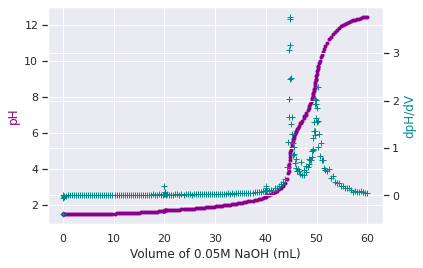

In [123]:
# creating a plot that can have two y-axis
fig, titration_curve = plt.subplots()

# plotting the two sets of data
derivative_curve = titration_curve.twinx()
titration_curve.plot(volumes, pHs, '.', color='darkmagenta')
derivative_curve.plot(volumes, derivatives_list, '+', color='darkcyan')

# labelling the axes and adding color 
titration_curve.set_xlabel('Volume of 0.05M NaOH (mL)')
titration_curve.set_ylabel('pH', color='darkmagenta')
derivative_curve.set_ylabel('dpH/dV', color='darkcyan');

# Woah, that's way too far away. Let's zoom in.
To zoom in on the important parts of our graph, adjust the min_x and max_x variables to your liking. For my data, I chose 40 and 55 because I felt like it.

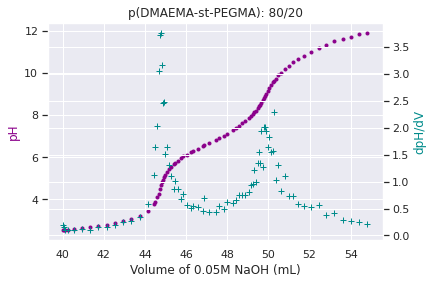

In [124]:
# trimming to look at just a region
min_x = 40
max_x = 55

# trimming our data fram to only include the volumes that are greater than our minimum x value and less than our maximum x value
trimmed_df = concat_df[(concat_df["Volume (mL)"] > min_x) 
                       & (concat_df["Volume (mL)"] < max_x)]

# saving our volumes, pH, and derivatives as variables from our newest trimmed dataframe
volumes = trimmed_df["Volume (mL)"]
pHs = trimmed_df["E(pH)"]
derivatives_list = trimmed_df["dpH/dV"]


# creating a plot that can have two y-axis
fig, titration_curve = plt.subplots()

# plotting the two sets of data
derivative_curve = titration_curve.twinx()
titration_curve.plot(volumes, pHs, '.', color='darkmagenta')
derivative_curve.plot(volumes, derivatives_list, '+', color='darkcyan')

# labelling the axes and adding color 
titration_curve.set_title('p(DMAEMA-st-PEGMA): 80/20')
titration_curve.set_xlabel('Volume of 0.05M NaOH (mL)')
titration_curve.set_ylabel('pH', color='darkmagenta')
derivative_curve.set_ylabel('dpH/dV', color='darkcyan');

# Let's quantitatively locate our inflection points
Below, I set a region of interest around our two inflection points to locate them. You need to chance the values for region 1 and region two so that each inflection point is in the middle of them. For example, I choose region 1 to be between 44 and 46 and regino 2 to be between 48 and 52. 

In [125]:
# need to change these according to location of inflection pt. on plot above!
region_1 = [44, 46]
region_2 = [48, 52]

# finding our two infl
inflection_pt_1 = concat_df[(concat_df["Volume (mL)"]  >= region_1[0]) & 
                                  (concat_df["Volume (mL)"] <= region_1[1]) &
                                  (concat_df["dpH/dV"] != np.inf) ]
inflection_pt_2 = concat_df[(concat_df["Volume (mL)"]  >= region_2[0]) & 
                                  (concat_df["Volume (mL)"] <= region_2[1]) &
                                  (concat_df["dpH/dV"] != np.inf) ]

# printing the rows of data for the two inbflection points 
print(inflection_pt_1.sort_values(by="dpH/dV")[-1:])
#print()
print(inflection_pt_2.sort_values(by="dpH/dV")[-1:])

     Row Data #  Volume (mL)  E(pH)  Cycle Number    dpH/dV
130          21       44.763  4.665             2  3.765957
     Row Data #  Volume (mL)  E(pH)  Cycle Number    dpH/dV
176          67       50.259  9.633             2  2.285714


In [126]:
# saving the rows of the two inflectino points
first_infl_pt = inflection_pt_1.sort_values(by="dpH/dV", ascending=False)[:1]
second_infl_pt = inflection_pt_2.sort_values(by="dpH/dV", ascending=False)[:1]

# finding the volume of the first inflection pt and the volume of the second inflection pt
inflection_pts_volume = [first_infl_pt["Volume (mL)"].values[0], second_infl_pt["Volume (mL)"].values[0]]

print(inflection_pts_volume)

[44.763, 50.259]


# Calculating the midpoint
Knowing the volumes of the two inflection points, we can calculate the mean to determine the volume of the midpoint

In [127]:
# finding the average of the two inflection points
volume_midpoint = np.mean(inflection_pts_volume)

# the volume of our midpoint
volume_midpoint

47.510999999999996

# Creating a dataframe of the most important info
In the following code, I create a dataframe of all the data between the two inflection points. Knowing the volume of our midpoint, you should rememeber that value and locate it in the midpoint dataframe. 

For example, since my midpoint volume is at 47.5mL, my pH is around 6.85. Remeber this value because it'll be used later for our chi-squared test. 

In [128]:
# creating a dataframe of everything between the two inflection points to help us find the midpoint
midpoint_df = concat_df[(concat_df["Volume (mL)"]  >= inflection_pts_volume[0]) & (concat_df["Volume (mL)"] <= inflection_pts_volume[1])]

midpoint_df

# sometimes this df is too long to print, so the following code will lock certain regions
#midpoint_df.loc['10':'12','E(pH)']

,Row Data #,Volume (mL),E(pH),Cycle Number,dpH/dV
130,21,44.763,4.665,2,3.765957
131,22,44.809,4.811,2,3.173913
132,23,44.859,4.934,2,2.460000
133,24,44.917,5.078,2,2.482759
134,25,44.981,5.175,2,1.515625
135,26,45.063,5.310,2,1.646341
136,27,45.155,5.430,2,1.304348
137,28,45.264,5.551,2,1.110092
138,29,45.393,5.662,2,0.860465
139,30,45.459,5.729,2,1.015152


In [129]:
# again, sometimes this df is too long to print, so the following code will lock certain regions
#midpoint_df.loc['10':'12','Volume (mL)']

In [130]:
for i,vol in enumerate(midpoint_df["Volume (mL)"]):
  if vol > volume_midpoint:
    top_index = i
    bottom_index = top_index -1
    break

# We're going to normalize the x-axis

In [131]:
# creating the variable alpha to normalize our x-axis
alpha = (midpoint_df['Volume (mL)'] - inflection_pts_volume[0]) / (inflection_pts_volume[1] - inflection_pts_volume[0])

#alpha
#print(len(alpha))

# Now lets visualize the data we've narrowed down and the new x-axis we've normalized

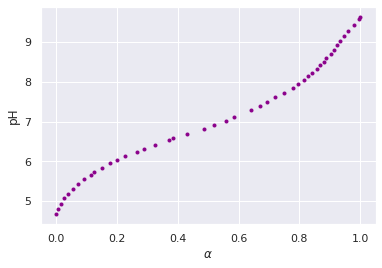

In [132]:
# plotting the dataframe thats zoomed in on everything between the inflection points on a normalized x-axis
plt.plot(alpha, midpoint_df["E(pH)"], '.', color='darkmagenta')
plt.xlabel(r'$\alpha$')
plt.ylabel("pH");

# Performing a chi-square test
We're going to use a chi-square test to best approximate the pKa. This is because the value of our pKa doesn't exist in our data. As we saw earlier, our midpoint volume was between two data points, meaning that the pKa isn't a value we cna locate. Instead, we're going to calculate it by performing a chi-squared test. 

# I found a [paper](https://onlinelibrary.wiley.com/doi/10.1002/pol.1947.120020409) that modifies the Hendersen-Hasselbach equation:
# $$ pH = pKa + log([A-]/[HA])$$ 
# to model cationic copolymers: 
# $$pH = pKa - n log((1-a)/a)$$

# The following code uses three different 'fits' to see which value of $n$ 'fits' our actual data the best.

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


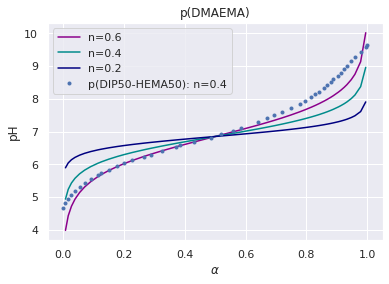

In [133]:
fit1 = 6.85 - 0.6 * np.log((1 - alpha) / alpha)
fit2 = 6.85 - 0.4 * np.log((1 - alpha) / alpha)
fit3 = 6.85 - 0.2 * np.log((1 - alpha) / alpha)

fits = [fit1, fit2, fit3]

#for fit in fits:
  #plt.plot(alpha, fit)

plt.plot(alpha, fit1, color='darkmagenta')
plt.plot(alpha, fit2, color='darkcyan')
plt.plot(alpha, fit3, color='navy')

plt.plot(alpha, midpoint_df["E(pH)"], '.')
plt.xlabel(r'$\alpha$')
plt.ylabel('pH')
plt.title('p(DMAEMA)')
plt.legend(["n=0.6","n=0.4","n=0.2",'p(DIP50-HEMA50): n=0.4']);

# We see that $n=0.6$ best fits our real data

# Now, let's set up information for the chi-squared test to estimate our value of pKa

For a given fit, the chi-squared value is defined as:

$$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$

In [134]:
# creating a chi-squared function with the parameters
def chi_squared(params,data,alpha):

  # indexing values for alpha and data
  data = data.values[1:-1]
  alpha = alpha.values[1:-1]

  # setting my parameters
  pKa = params[0]
  n = params[1]
  chi_squared = 0

  # fitting the parameters with our cationic Henderson-Hasselbach equation
  fit = pKa - n * np.log((1 - alpha) / alpha)

  # using the chi_sqaured equation to fit 
  for i in range(len(data)):
    chi = (data[i] - fit[i])** 2 / fit[i]
    #print(chi)
    chi_squared += chi 

  return chi_squared

# Earlier I said to remember the estimated value of our pKa from our midpoint dataframe. In the following code, place this number, along wiht the best fit number, in the chi_sqaured function.
For this example, I inserted 6.85 and 0.6. 

In [135]:
chi_squared([6.85,0.6], midpoint_df["E(pH)"], alpha)

0.6970076964600526

# Performing the chi-squared test
Add our pKa guess and the best fit value to the following code. Be sure to change the bounds so that they fit around the pKa value and fit around the n value. For example, I added 6 and 7 to include the 6.85 pKa guess and the 0.5 and 0.7 to include the best fit. 

In [136]:
ans = scipy.optimize.minimize(chi_squared, [6.85,0.6], args=(midpoint_df["E(pH)"],alpha), 
                        bounds=[(6,7),(0.5,0.7)])
ans.x

# the pKa estimation 
best_pKa = ans.x[0]

# the n estimation
best_n = ans.x[1]

0.5969327973638133

In [141]:
# printing the best n value
best_n

0.5969327973638133

In [140]:
# printing the best pKa
best_pKa

7.0

# Now, let's see how well our data fits with our chi-sqaured fit

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


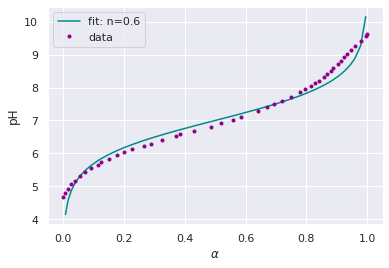

In [143]:
# plot the best fit
fit = best_pKa - best_n * np.log((1-alpha) / alpha)
plt.plot(alpha, fit, color="darkcyan")

# plot the data
plt.plot(alpha, midpoint_df["E(pH)"], '.', color='darkmagenta')

# labels
plt.xlabel(r'$\alpha$')
plt.ylabel('pH')
plt.legend(["fit: n=0.6","data"]);